### Вариант 2
Найти аналитическое и численное решения смешанной задачи для квазилинейного уравнения теплопроводности и сравнить их значения в момент времени T = 1

### Задание 15
$$
\begin{cases}
\frac{\partial u}{\partial t} = \frac{\partial}{r^2 \partial r}
(r^2u^{1/2}\frac{\partial u}{\partial r}) + \frac{\partial}{r^2 sin \theta \partial \theta} (sin \theta u^{1/2} \frac{\partial u}{\partial \theta}), \; 0<t\leq 1, 0 < r< 1, \; 0 < \theta < \pi/2 \\
u(0, r, \theta) = r^4 sin^4 \theta /196 \\
u(t, 0, \theta) = 0, \; u(t, r, 0) = 0 \\
u(t, 1, \theta) = sin^4 \theta / (14-12t)^2 \\
u(t, r, \pi/2) = r^4/(14-12t)^2
\end{cases}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('dark_background')

#### Аналитическое решние
Воспользуемся материалом на странице 180 из пособия для нахождения численного решения, здесь $\mu = 1/2$, $C_l = 14$. Таким образом имеем:
$$
u = r^4 sin^4 \theta(14-12t)^{-2}
$$

In [2]:
# analytical solution
def a_sol(r, theta, t):
    return r**4 * np.sin(theta)**4 / ((14-12*t)**(2))

#### Численное решение
Пользуемся неявной четырехточечной схемой. Применяем метод расщепления по направлениям и последующую (уже возможную) прогонку

In [3]:
def forw_prop(a, b, c, d):
    N = a.shape[0]
    alpha = np.zeros(N)
    betta = np.zeros(N)
    alpha[0] = - a[0]/b[0]
    betta[0] = d[0]/b[0]
    for l in range(1, N):
        alpha[l] = - a[l]/(b[l]+c[l]*alpha[l-1])
        betta[l] = (d[l]-c[l]*betta[l-1])/(b[l]+c[l]*alpha[l-1])
        
    return alpha, betta

def back_prop(alpha, betta, uL):
    N = alpha.shape[0]
    u = np.zeros(N+1)
    u[-1] = uL
    for l in range(N-1, -1, -1):
        u[l] = alpha[l]*u[l+1]+betta[l]
        
    return u

In [4]:
def solve_sub(u, u_k, tau, h_r, h_th, t):
    Nr = u_k.shape[0]
    Nth = u_k.shape[1]
    
    u_sol = np.zeros((Nr, Nth))
    r = np.linspace(0, 1, Nr)
    theta = np.linspace(0, np.pi/2, Nth)

    for j in range(1, Nth-1):
        a = - (r[1:-1]+h_r/2)**2 * (u_k[2:, j]**(1/2)+u_k[1:-1, j]**(1/2)) \
            * tau / (2*r[1:-1]**2*h_r**2)
        c = - (r[1:-1]-h_r/2)**2 * (u_k[1:-1, j]**(1/2)+u_k[:-2, j]**(1/2)) \
            * tau / (2*r[1:-1]**2*h_r**2)
        b = 1 - a - c+2
        d = u[1:-1, j]+2*np.vectorize(a_sol)(r[1:-1], theta[j], t+tau)
        a = np.concatenate(([0], a), axis = 0)
        b = np.concatenate(([1], b), axis = 0)
        d = np.concatenate(([0], d), axis = 0)
        c = np.concatenate(([0], c), axis = 0)

        u_L = np.sin(theta[j])**4*(14-12*(tau+t))**(-2)
        
        alpha, betta = forw_prop(a, b, c, d)
        u_sol[:, j] = back_prop(alpha, betta, u_L)
    
    u_sol[:, -1] = r**4*(14-12*(t+tau))**(-2)
    #u_sol[-1, :] = np.sin(theta)**4*(14-12*(tau+t))**(-2)
    return u_sol

def solve_sys(u_sub, u_k, tau, h_r, h_th, t):
    Nr = u_k.shape[0]
    Nth = u_k.shape[1]
    
    u_sol = np.zeros((Nr, Nth))
    r = np.linspace(0, 1, Nr)
    theta = np.linspace(0, np.pi/2, Nth)
    
    for i in range(1, Nr-1):
        a = -np.sin(theta[1:-1]+h_th/2)*(u_k[i, 2:]**(1/2)+u_k[i, 1:-1]**(1/2)) \
            *tau / (2*r[i]**2*np.sin(theta[1:-1])*h_th**2)
        c = -np.sin(theta[1:-1]-h_th/2)*(u_k[i, 1:-1]**(1/2)+u_k[i, :-2]**(1/2)) \
            *tau / (2*r[i]**2*np.sin(theta[1:-1])*h_th**2)
        b = 1 - a - c + 2
        d = u_sub[i, 1:-1]+2*np.vectorize(a_sol)(r[i], theta[1:-1], t+tau)
        
        a = np.concatenate(([0], a), axis = 0)
        b = np.concatenate(([1], b), axis = 0)
        d = np.concatenate(([0], d), axis = 0)
        c = np.concatenate(([0], c), axis = 0)
        
        u_M = r[i]**4*(12-14*(t+tau))**(-2)
        
        alpha, betta = forw_prop(a, b, c, d)
        u_sol[i, :] = back_prop(alpha, betta, u_M)

    u_sol[-1, :] = np.sin(theta)**4 / ( (14-12*(t+tau)) )**(2)
    return u_sol

In [5]:
def one_step(u, u_k, tau, h_r, h_th, t):
    u_sub = solve_sub(u, u_k, tau, h_r, h_th, t)
    return solve_sys(u_sub, u_k, tau, h_r, h_th, t)

# finally solve function that will cal all the precious functions
# we need only the solution on the T = 1, so we will store only one layer
def solve(Nr, Nth, Nt):
    # start layer
    r = np.linspace(0, 1, Nr)
    theta = np.linspace(0, np.pi/2, Nth)
    sol = np.zeros((Nr, Nth))
    for j in range(Nth):
        sol[:, j] = r**4*(np.sin(theta[j])**4)/196
    EPS = 1e-2
    
    tau = 1/(Nt-1)
    h_r = 1/(Nr-1)
    h_th = np.pi/2/(Nth-1)
    exit = False
    for i in range(0, Nt-1):
        t = tau*i
        prev_sol = np.copy(sol)
        for k in range(1):
            new_sol = one_step(sol, prev_sol, tau, h_r, h_th, t)
            if np.max(np.abs((new_sol[1:-1,1:-1]-prev_sol[1:-1,1:-1])/new_sol[1:-1, 1:-1])) < EPS:
                #print(k)
                sol = np.copy(new_sol)
                break
            prev_sol = np.copy(new_sol)
            if k == 7:
                print('progonka not converged')
                print(t)
                #exit = True
                #break
            sol = np.copy(new_sol)
        if(exit):
            break
                
    return sol

Теперь представим полученные результаты

#### Аналитическое решение
Таблица и график аналитического решения

In [6]:
Nr = 11
Nthet = 11

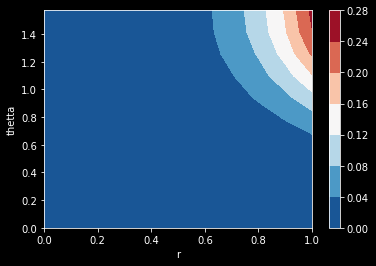

---таблица аналитического решения в проекции на сетку 11x11---
В следующей таблице по вертикали - угол, по горизонтали r


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.157080,0.0,1.497165e-08,2.395465e-07,0.000001,0.000004,0.000009,0.000019,0.000036,0.000061,0.000098,0.000150
0.314159,0.0,2.279657e-07,3.647451e-06,0.000018,0.000058,0.000142,0.000295,0.000547,0.000934,0.001496,0.002280
0.471239,0.0,1.062006e-06,1.699210e-05,0.000086,0.000272,0.000664,0.001376,0.002550,0.004350,0.006968,0.010620
0.628319,0.0,2.984109e-06,4.774575e-05,0.000242,0.000764,0.001865,0.003867,0.007165,0.012223,0.019579,0.029841
0.785398,0.0,6.250000e-06,1.000000e-04,0.000506,0.001600,0.003906,0.008100,0.015006,0.025600,0.041006,0.062500
0.942478,0.0,1.070953e-05,1.713525e-04,0.000867,0.002742,0.006693,0.013880,0.025714,0.043866,0.070265,0.107095
1.099557,0.0,1.575664e-05,2.521062e-04,0.001276,0.004034,0.009848,0.020421,0.037832,0.064539,0.103379,0.157566
1.256637,0.0,2.045339e-05,3.272542e-04,0.001657,0.005236,0.012783,0.026508,0.049109,0.083777,0.134195,0.204534
1.413717,0.0,2.379138e-05,3.806622e-04,0.001927,0.006091,0.014870,0.030834,0.057123,0.097450,0.156095,0.237914


In [7]:
r = np.linspace(0, 1, Nr)
thet = np.linspace(0, np.pi/2, Nthet)

rv, thetv = np.meshgrid(r, thet, sparse=False, indexing='ij')

func = lambda x, y : a_sol(x, y, 1)

anal = np.vectorize(func)(rv, thetv)

df = pd.DataFrame(anal, columns = thet, index=r, dtype = float) 
plt.xlabel('r')
plt.ylabel('thetta')
cs = plt.contourf(rv, thetv, anal, cmap='RdBu_r')
cbar = plt.colorbar(cs)
plt.show()
print('---таблица аналитического решения в проекции на сетку 11x11---')
print('В следующей таблице по вертикали - угол, по горизонтали r')
df.T

#### Численное решение
Таблица и график аналитического решения

In [8]:
Nr = 21
Nthet = 21
Nt = 101

In [9]:
comp = solve(Nr, Nthet, Nt)
comp.shape

(21, 21)

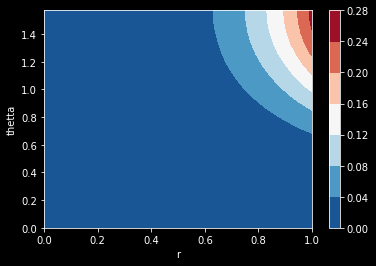

---таблица численного решения в проекции на сетку 11x11---
В следующей таблице по вертикали - угол, по горизонтали r


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.157080,0.0,1.558991e-08,2.494014e-07,0.000001,0.000004,0.000010,0.000020,0.000037,0.000064,0.000102,0.000150
0.314159,0.0,2.346068e-07,3.751672e-06,0.000019,0.000060,0.000147,0.000304,0.000563,0.000960,0.001538,0.002280
0.471239,0.0,1.087673e-06,1.738273e-05,0.000088,0.000278,0.000679,0.001408,0.002608,0.004448,0.007127,0.010620
0.628319,0.0,3.042933e-06,4.859407e-05,0.000246,0.000777,0.001897,0.003934,0.007288,0.012433,0.019920,0.029841
0.785398,0.0,6.346023e-06,1.012589e-04,0.000512,0.001619,0.003953,0.008196,0.015183,0.025902,0.041499,0.062500
0.942478,0.0,1.083086e-05,1.726793e-04,0.000874,0.002761,0.006739,0.013973,0.025886,0.044160,0.070747,0.107095
1.099557,0.0,1.588105e-05,2.530115e-04,0.001280,0.004044,0.009872,0.020469,0.037921,0.064689,0.103620,0.157566
1.256637,0.0,2.056535e-05,3.274524e-04,0.001656,0.005233,0.012775,0.026488,0.049069,0.083705,0.134054,0.204534
1.413717,0.0,2.393408e-05,3.809974e-04,0.001927,0.006089,0.014863,0.030817,0.057088,0.097377,0.155871,0.237914


In [10]:
r = np.linspace(0, 1, Nr)
thet = np.linspace(0, np.pi/2, Nthet)
rv, thetv = np.meshgrid(r, thet, sparse=False, indexing='ij')
plt.xlabel('r')
plt.ylabel('thetta')
cs = plt.contourf(rv, thetv, comp, cmap='RdBu_r')
cbar = plt.colorbar(cs)
plt.show()
print('---таблица численного решения в проекции на сетку 11x11---')
print('В следующей таблице по вертикали - угол, по горизонтали r')

r = np.linspace(0, 1, 11)
thet = np.linspace(0, np.pi/2, 11)
rv, thetv = np.meshgrid(r, thet, sparse=False, indexing='ij')
df = pd.DataFrame(comp[::(Nr-1)//10, ::(Nthet-1)//10], columns = thet, index=r, dtype = float)
df.T

In [11]:
print('---таблица модуля разности аналитического решения и численного---')
print('В следующей таблице по вертикали - угол, по горизонтали r')

r = np.linspace(0, 1, 11)
thet = np.linspace(0, np.pi/2, 11)
rv, thetv = np.meshgrid(r, thet, sparse=False, indexing='ij')
df = pd.DataFrame(np.abs(comp[::(Nr-1)//10, ::(Nthet-1)//10] - anal), columns = thet, index=r, dtype = float)
df.T

---таблица модуля разности аналитического решения и численного---
В следующей таблице по вертикали - угол, по горизонтали r


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.0
0.157080,0.0,6.182533e-10,9.854965e-09,4.985776e-08,1.575390e-07,3.845762e-07,7.974116e-07,0.000001,0.000003,0.000004,0.0
0.314159,0.0,6.641170e-09,1.042207e-07,5.258042e-07,1.659818e-06,4.050059e-06,8.395696e-06,0.000016,0.000027,0.000043,0.0
0.471239,0.0,2.566655e-08,3.906267e-07,1.959726e-06,6.174213e-06,1.505183e-05,3.118683e-05,0.000058,0.000098,0.000159,0.0
0.628319,0.0,5.882384e-08,8.483194e-07,4.212053e-06,1.322188e-05,3.217840e-05,6.661096e-05,0.000123,0.000210,0.000341,0.0
0.785398,0.0,9.602343e-08,1.258920e-06,6.126675e-06,1.909366e-05,4.631201e-05,9.569176e-05,0.000177,0.000302,0.000493,0.0
0.942478,0.0,1.213304e-07,1.326776e-06,6.170777e-06,1.890568e-05,4.548479e-05,9.356287e-05,0.000173,0.000294,0.000481,0.0
1.099557,0.0,1.244129e-07,9.052793e-07,3.618848e-06,1.038324e-05,2.416382e-05,4.877314e-05,0.000089,0.000150,0.000241,0.0
1.256637,0.0,1.119611e-07,1.981019e-07,4.121934e-07,2.849828e-06,8.698247e-06,1.999962e-05,0.000039,0.000072,0.000141,0.0
1.413717,0.0,1.426905e-07,3.352124e-07,3.294255e-08,1.995463e-06,7.000894e-06,1.695097e-05,0.000035,0.000073,0.000224,0.0


In [12]:
# погрешность
print('Погрешность решения:')
print(np.max(np.abs(comp[::(Nr-1)//10, ::(Nthet-1)//10] - anal)))

Погрешность решения:
0.0004927986861405151


#### Порядок апроксимации

In [13]:
M = 6
err_r = np.zeros(M)

A = 10
B = 10

for i in range(1, M+1):
    Nr = A*(i)+1
    Nthet = A*(i)+1
    Nt = B*(i**2)+1
    comp = solve(Nr, Nthet, Nt)
    err_r[i-1] = np.max(np.abs(comp[::(Nr-1)//10, ::(Nthet-1)//10] - anal))

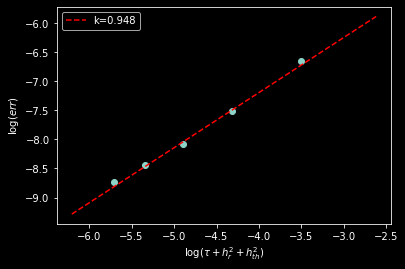

In [14]:
from scipy.optimize import curve_fit

def f(x, a, b):
    return a*x+b

a = np.arange(1, M+1)
step = 1/(B*(a**2))+1/(A*a)**2+1/(A*a)**2

plt.xlabel(r'$\log(\tau+h_r^2+h_{th}^2)$')
plt.ylabel('$\log(err)$')

popt, pcov = curve_fit(f, np.log(step)[1:], np.log(err_r)[1:])

mn = np.min(step)
mx = np.max(step)

plt.plot([np.log(mn)-0.5, np.log(mx)-0.5], 
         [popt[0]*np.log(mn)-0.5+popt[1], popt[0]*np.log(mx)-0.5+popt[1]],
         color='r', linestyle='--', label='k={:.3}'.format(popt[0]))
plt.scatter(np.log(step)[1:], np.log(err_r)[1:])
plt.legend()
plt.show()

In [15]:
for i in range(1, M):
    Nr = A*(i+1)+1
    Nthet = A*(i+1)+1
    Nt = B*((i+1)**2)+1
    print('Nr:', Nr, 'Nthet:', Nthet, 'Nt:', Nt)
    print('error:', err_r[i])

Nr: 21 Nthet: 21 Nt: 41
error: 0.001288401485870963
Nr: 31 Nthet: 31 Nt: 91
error: 0.0005464872100815546
Nr: 41 Nthet: 41 Nt: 161
error: 0.00031151281724503543
Nr: 51 Nthet: 51 Nt: 251
error: 0.0002140396978503878
Nr: 61 Nthet: 61 Nt: 361
error: 0.00016240609087170288
